<h1><center> PathLinker Cytoscape automation example </center></h1>
<img src="http://apps.cytoscape.org/media/pathlinker/logo.png.png" alt="PathLinker Logo">

## Requirments
* Java 8
* Cytoscape 3.6.0+
* cyREST 3.6.0+
* py2cytoscape 0.4.2+

## This notebook is based on the following scripts:
* [New_wrapper_api_sample](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/New_wrapper_api_sample.ipynb)
* [basic1](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/basic1.ipynb)

In [1]:
# necessary libraries and dependencies
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import networkx as nx
import pandas as pd
import json
import requests

In [2]:
# !!!!!!!!!!!!!!!!! Step 0: Start Cytoscape 3.6 with cyREST App !!!!!!!!!!!!!!!!!!!!!!!!!!
# Cytoscape must be running to use the automation features

# Step 1: create an instance of cyRest client
cy = CyRestClient()

# Reset the session
cy.session.delete()

## Create network using networkx

To create a network that PathLinker will run on, the example uses the [graph-undir_human-interactome.txt](https://github.com/Murali-group/PathLinker-Cytoscape/blob/master/src/test/resources/input/graph-dir_human-interactome.txt). <br>
To learn more about the sample file please visit the [PathLinker paper](http://bioinformatics.cs.vt.edu/~murali/supplements/2016-sys-bio-applications-pathlinker/).

In [3]:
# Step 2: Import/Create the network that PathLinker will run on

# Store the sample text file into csv_directory
# Please modify the csv_directory if you want to create network using different text files
csv_directory = 'example_attachment/graph-dir_human-interactome.txt'

# create a new network by importing the data from a sample using pandas
network_csv = pd.read_csv(csv_directory, header=None, sep='\t', lineterminator='\n')

# initialize an empty graph from networkx
nx_network = nx.Graph()

# fill the empty network with source, target, and corresponding edge weight
# from the data inside the network_csv
for row in network_csv.itertuples():
    nx_network.add_edge(row[1], row[2], weight=row[3])
    
# create the CyNetwork object from the networkx in CytoScape
cy_network = cy.network.create_from_networkx(nx_network, collection = 'Generated by NetworkX')

# obtain the CyNetwork object SUID
cy_network_suid = cy_network.get_id()

The network shown below will be generated in Cytoscape with the above code. Do notice that there are no visual style applied to the network, hence the reason of only a square in the center (all the other nodes are hidden behind the square).

Looking at the Edge Table in the Table Panel, the network consists of <b>'source' column, 'target' column, and 'weight' column</b>. The 'weight' column will be used for the <b>'edgeWeightColumnName"</b> input for running the function. 

<img src = "example_attachment/networkX.png">

## Use PathLinker API function

PathLinker consist of one API function "run".

### run
POST function that takes user input network SUID, sources, targets, and a set of parameters, and computes the k shortest paths. The function returns the paths in JSON format. Based on the user input, the function could generate a subnetwork (and view) containing those paths, and returns the computed paths and subnetwork/view SUIDs.

In [4]:
# Step 3: Construct input data to pass to PathLinker API function

# construct PathLinker input data for API request
input_data = {}

# the node names as shown in the "source" column in the Node Table in Cytoscape
input_data["sources"] = "P35968 P00533 Q02763"

# the node names as shown in the "target" column in the Node Table in Cytoscape
input_data["targets"] = "Q15797 Q14872 Q16236 P14859 P36956"

# the number of shortest path to compute, must be greater than 0
input_data["k"] = 50

# Edge weight type, must be one of the three: [UNWEIGHTED, ADDITIVE, PROBABILITIES]
input_data["edgeWeightType"] = "PROBABILITIES"

# Edge penalty, uneeded for UNWEIGHTED, 0 or greater for ADDITIVE, and 1 or greater for PROBABILITIES 
input_data["edgePenalty"] = 1

# The column name in the Edge Table in Cytoscape containing edge weight property, 
# column type must be numerical type 
input_data["edgeWeightColumnName"] = "weight"

# Allow source/target nodes to appear as intermediate nodes in computed paths
# optional parameter, default is set to False
# input_data["allowSourcesTargetsInPaths"] = False

# Include more than k paths if the path length/score is equal to kth path length/score
# optional parameter, default is set to False
# input_data["includeTiedPaths"] = False

# Option to disable the generation of the subnetwork/view, path rank column, and result panel
# and only return the path result in JSON format
input_data["skipSubnetworkGeneration"] = False

# perform REST API call
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

# construct REST API request url
url = "http://localhost:1234/pathlinker/v1/" + str(cy_network_suid) + "/run"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(input_data),
                          params = None,
                          headers = headers)

The subnetwork shown below will be generated by running the run function with above input.

<img src = "example_attachment/subnetwork.png">

## Output

the following section stores the subnetwork/view references and prints out the path output returned by the run function.

The output consist of path result in JSON format, and based on user input: subnetwork SUID, subnetwork view SUID, and path rank column name.

In [5]:
# Step 4: Store result, parse, and print

parsed = json.loads(result_json.content)

print("Output:\n")

# if subnetwork is generated, then access the suid, references, and path rank column name
if not input_data["skipSubnetworkGeneration"]:
    subnetwork_suid = parsed["subnetworkSUID"]
    subnetwork_view_suid = parsed["subnetworkViewSUID"]
    path_rank_column_name = parsed["pathRankColumnName"]
    
    print("subnetwork SUID:      ", subnetwork_suid)
    print("subnetwork view SUID: ", subnetwork_view_suid)
    print("Path rank column name:", path_rank_column_name)
    print("\n")
    
    # access network and network view references
    subnetwork_ref = cy.network.create(suid=subnetwork_suid)
    subnetwork_view_ref = subnetwork_ref.get_first_view()

# Access the paths generated by PathLinker
paths = parsed["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:10]:
    print("path rank: ", path['rank'])
    print("path score:", path['score'])
    print("path:", " " * 5, "|".join(path['nodeList']), "\n")

Output:

subnetwork SUID:       622234
subnetwork view SUID:  622247
Path rank column name: path rank 2


path rank:  1
path score: 0.5625
path:       P00533|P0CG47|Q16236 

path rank:  2
path score: 0.5625
path:       P00533|P24385|P14859 

path rank:  3
path score: 0.5625
path:       P00533|P27361|Q15797 

path rank:  4
path score: 0.5625
path:       P00533|P41743|P36956 

path rank:  5
path score: 0.5625
path:       P00533|Q05513|P36956 

path rank:  6
path score: 0.5625
path:       P00533|Q9HAU4|Q15797 

path rank:  7
path score: 0.502197
path:       P00533|P27361|P36956 

path rank:  8
path score: 0.502197
path:       P00533|P28482|P36956 

path rank:  9
path score: 0.472237
path:       P00533|Q13153|Q15797 

path rank:  10
path score: 0.421875
path:       P00533|O00206|P05412|Q16236 



## Visualization using cytoscape.js and py2cytoscape

run the following section only if there exists subnetwork_ref and subnetwork_view_ref

In [6]:
import py2cytoscape.cytoscapejs as renderer

# visualize the subnetwork view using CytoScape.js
renderer.render(subnetwork_view_ref, 'Directed', background='radial-gradient(#FFFFFF 15%, #DDDDDD 105%)')
    

<IPython.core.display.Javascript object>

## Access and store the pdf image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref

In [7]:
# pdf
subnetwork_pdf = subnetwork_ref.get_pdf()

f = open('example_attachment/subnetwork.pdf', 'wb')
f.write(subnetwork_pdf)
f.close()

from IPython.display import IFrame
IFrame('example_attachment/subnetwork.pdf', width=600, height=300)

## Show PNG image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref

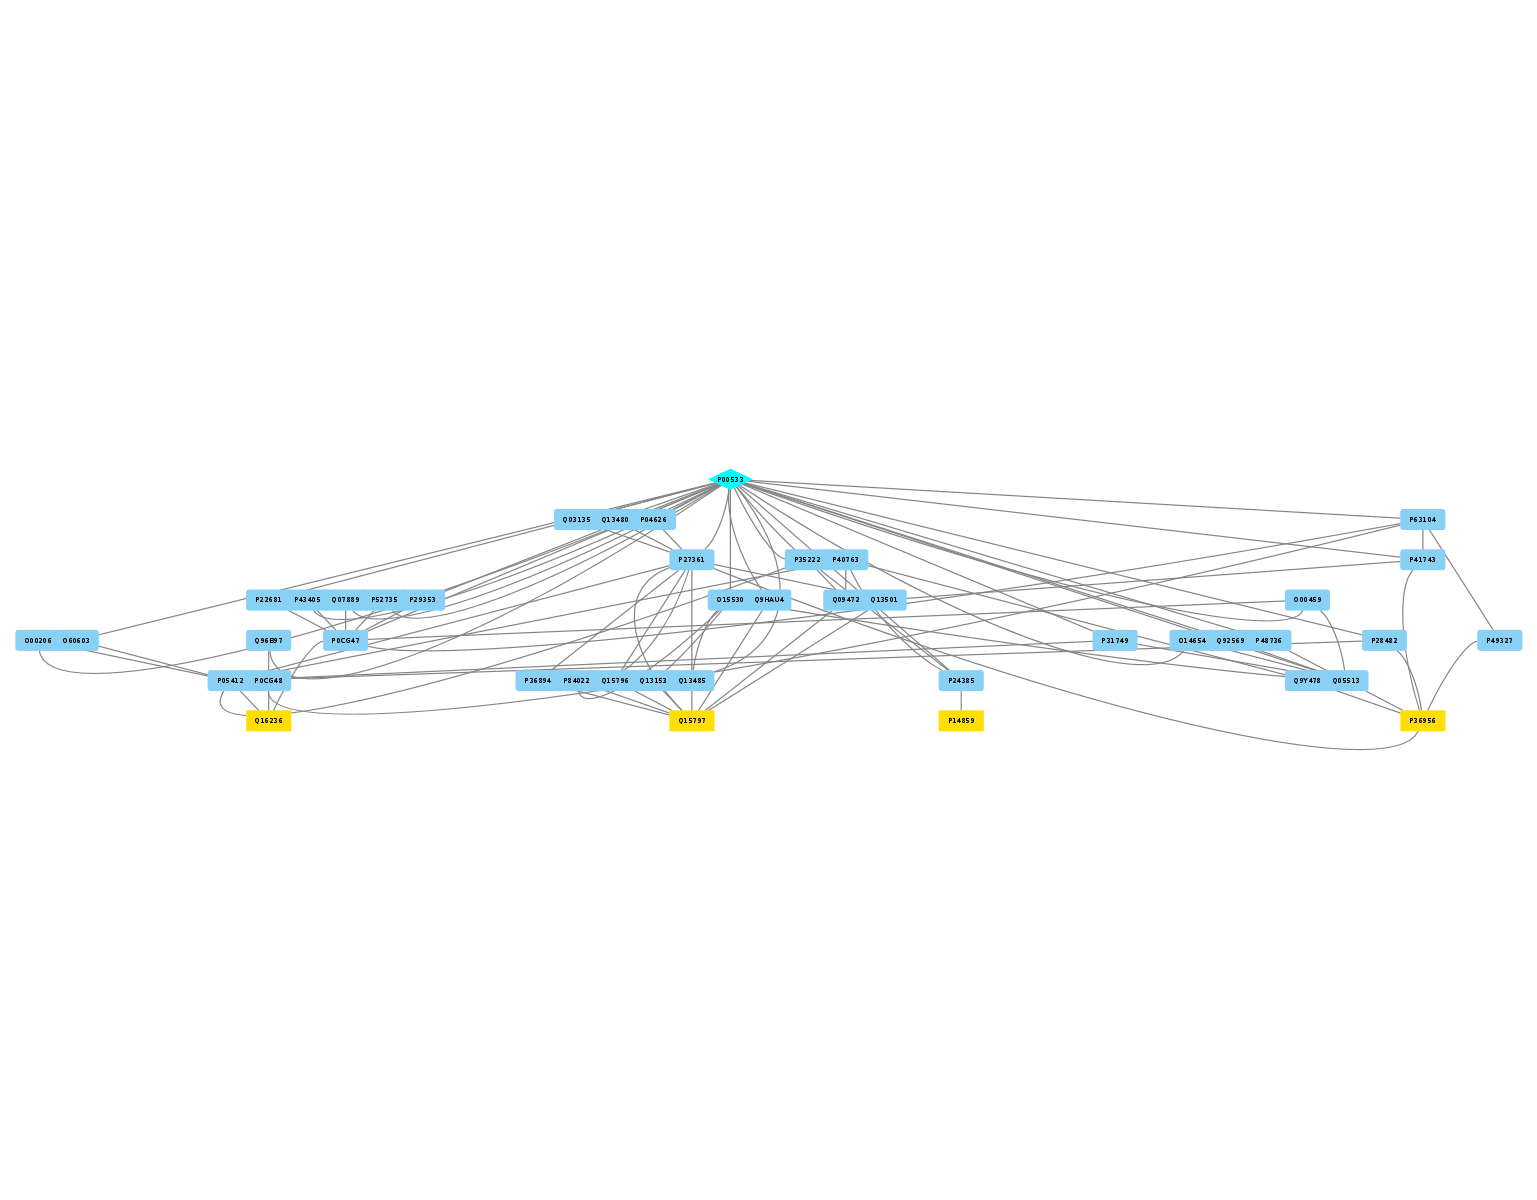

In [8]:
#png
subnetwork_png = subnetwork_ref.get_png()

from IPython.display import Image
Image(subnetwork_png)

## Show SVG image

run the following section only if there exists subnetwork_ref and subnetwork_view_ref

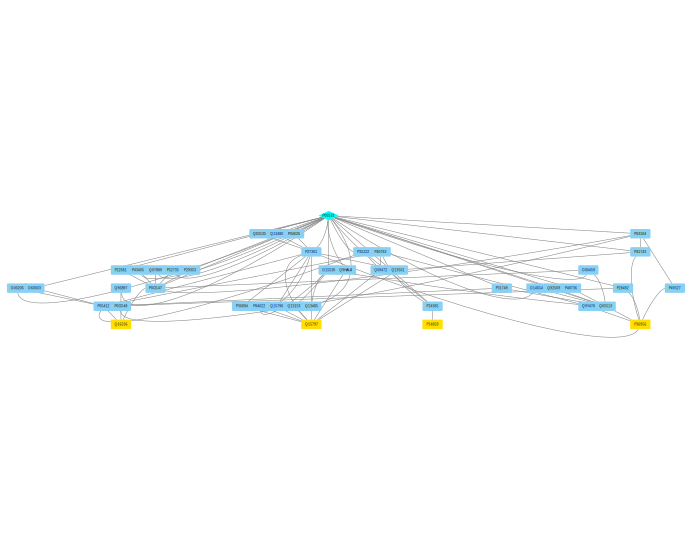

In [9]:
#svg
subnetwork_svg = subnetwork_ref.get_svg()

from IPython.display import SVG
SVG(subnetwork_svg)